# 空間資料處理 (geopandas) 

In [1]:
import geocoder
import geopandas as gpd
import json
import pandas as pd
from shapely.geometry import LineString, Point, Polygon

from src.func import Preload

## Data structures

GeoPandas implements two main data structures, a GeoSeries and a GeoDataFrame. These are subclasses of pandas.Series and pandas.DataFrame, respectively.

GeoPandas has three basic classes of geometric objects (which are actually shapely objects):
- Points / Multi-Points
- Lines / Multi-Lines
- Polygons / Multi-Polygons

Note that all entries in a GeoSeries need not be of the same geometric type, although certain export operations will fail if this is not the case.


### Read data

In [2]:
# 身障社區長照機構
long_term_care = pd.read_csv('Datasets/Raw/身障社區長照機構_2023-06-11.csv', encoding='big5')
long_term_care

,機構類型,機構名稱,地址,電話
0,身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272
1,身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032
2,身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605
3,身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933


### Point

### address to coordinate

Due to the fact that many open datasets only contain address information and lack latitude and longitude data, obtaining coordinates is essential for preprocessing the data and performing certain tasks. There are various methods available for converting addresses into latitude and longitude coordinates. In our case, we use the "geocoder" package to accomplish this, but you are free to choose your preferred method.

In [3]:
addr_0 = long_term_care.loc[0, '地址']
addr_0_info = geocoder.arcgis(addr_0)
addr_0_info.json

{'address': '台北市士林區前港里後港街189號, 11159',
 'bbox': {'northeast': [25.089019988075, 121.521929970555],
  'southwest': [25.087019988075, 121.519929970555]},
 'confidence': 9,
 'lat': 25.088019988074905,
 'lng': 121.52092997055541,
 'ok': True,
 'quality': 'PointAddress',
 'raw': {'name': '台北市士林區前港里後港街189號, 11159',
  'extent': {'xmin': 121.519929970555,
   'ymin': 25.087019988075,
   'xmax': 121.521929970555,
   'ymax': 25.089019988075},
  'feature': {'geometry': {'x': 121.52092997055541, 'y': 25.088019988074905},
   'attributes': {'Score': 98.67, 'Addr_Type': 'PointAddress'}}},
 'score': 98.67,
 'status': 'OK'}

In [4]:
# get lng and lat of addr_0
addr_0_lng = addr_0_info.json['lng']
addr_0_lat = addr_0_info.json['lat']

In [5]:
# get lng and lat of addr_1
addr_1 = long_term_care.loc[1, '地址']
addr_1_info = geocoder.arcgis(addr_1)
addr_1_lng = addr_1_info.json['lng']
addr_1_lat = addr_1_info.json['lat']

In [6]:
# transfer string to Point
point0 = Point(addr_0_lng, addr_0_lat)
point1 = Point(addr_1_lng, addr_1_lat)

# get info of point0
print(type(point0))
print(point0.area)
print(point0.bounds) # minx, miny, maxx, maxy
print(point0.geom_type)
print(point0.is_valid)

<class 'shapely.geometry.point.Point'>
0.0
(121.52092997055541, 25.088019988074905, 121.52092997055541, 25.088019988074905)
Point
True


In [7]:
# get distance
print(point0.distance(point1))
print(point0.distance(point0))
print(point1.distance(point1))

print(((point0.x-point1.x)** 2 + (point0.y-point1.y)** 2)** (1/2))

0.03808041718070139
0.0
0.0
0.03808041718070139


### buffer

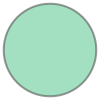

In [8]:
point0.buffer(1)

In [9]:
point0.buffer(1).area

3.13654849054594

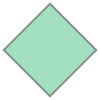

In [10]:
point0.buffer(1, resolution=1)

In [11]:
point0.buffer(1, resolution=1).area

2.0

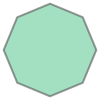

In [12]:
point0.buffer(1, resolution=2)

In [13]:
res_list = [10** x for x in range(8)]
for res in res_list:
    print(point0.buffer(1, resolution=res).area)

2.0
3.1286893008046204
3.1414634623641327
3.1415913616617597
3.141592640670475
3.141592653460551
3.1415926535884457
3.1415926535895258


### LineString

In [14]:
first_line_string = LineString([point0, point1])

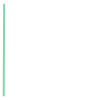

In [15]:
first_line_string

In [16]:
print(point0.x)
print(point0.y)
print('- '* 10)
print(point1.x)
print(point1.y)

121.52092997055541
25.088019988074905
- - - - - - - - - - 
121.52075001109426
25.049939996120486


In [17]:
# get info of point0
print(first_line_string.xy)
print(type(first_line_string))
print(first_line_string.area)
print(first_line_string.bounds) # minx, miny, maxx, maxy
print(first_line_string.geom_type)
print(first_line_string.is_valid)
print(first_line_string.length)
print(first_line_string.centroid)

(array('d', [121.52092997055541, 121.52075001109426]), array('d', [25.088019988074905, 25.049939996120486]))
<class 'shapely.geometry.linestring.LineString'>
0.0
(121.52075001109426, 25.049939996120486, 121.52092997055541, 25.088019988074905)
LineString
True
0.03808041718070139
POINT (121.52083999082485 25.068979992097695)


### Polygon

In [18]:
# get lat and lng of addr_2
addr_2 = long_term_care.loc[2, '地址']
addr_2_info = geocoder.arcgis(addr_2)
addr_2_lng = addr_2_info.json['lng']
addr_2_lat = addr_2_info.json['lat']
point2 = Point(addr_2_lng, addr_2_lat)

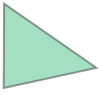

In [19]:
first_polygon = Polygon((point0, point1, point2))
first_polygon

## GeoSeries

In [20]:
# define a geoseries
s = gpd.GeoSeries(
    [
        Polygon([(0, 0), (0, 1), (1, 1), (1, 0)]),
        Polygon([(10, 0), (10, 5), (0, 0)]),
        Polygon([(0, 0), (2, 2), (2, 0)]),
        LineString([(0, 0), (1, 1), (0, 1)]),
        Point(0, 1)
    ]
)

In [21]:
s.length

0     4.000000
1    26.180340
2     6.828427
3     2.414214
4     0.000000
dtype: float64

In [22]:
s.area

0     1.0
1    25.0
2     2.0
3     0.0
4     0.0
dtype: float64

In [23]:
s.bounds

,minx,miny,maxx,maxy
0,0.0,0.0,1.0,1.0
1,0.0,0.0,10.0,5.0
2,0.0,0.0,2.0,2.0
3,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,1.0


In [24]:
s.boundary

0    LINESTRING (0.00000 0.00000, 0.00000 1.00000, ...
1    LINESTRING (10.00000 0.00000, 10.00000 5.00000...
2    LINESTRING (0.00000 0.00000, 2.00000 2.00000, ...
3        MULTIPOINT (0.00000 0.00000, 0.00000 1.00000)
4                             GEOMETRYCOLLECTION EMPTY
dtype: geometry

In [25]:
s.total_bounds

array([ 0.,  0., 10.,  5.])

In [26]:
s.geom_type

0       Polygon
1       Polygon
2       Polygon
3    LineString
4         Point
dtype: object

In [27]:
s.distance(Point(-1, -1))

0    1.414214
1    1.414214
2    1.414214
3    1.414214
4    2.236068
dtype: float64

## GeoDataFrame

In [28]:
d = {
    'col1': ['name1', 'name2'], 
    'geometry': [Point(1, 2), Point(2, 1)]
}
gdf = gpd.GeoDataFrame(d, crs='EPSG:4326', geometry='geometry')
gdf

,col1,geometry
0,name1,POINT (1.00000 2.00000)
1,name2,POINT (2.00000 1.00000)


###  crs (Coordinate Reference System)
The coordinate reference system (CRS) is important because the geometric shapes in a GeoSeries or GeoDataFrame object are simply a collection of coordinates in an arbitrary space. A CRS tells Python how those coordinates relate to places on the Earth.

The same CRS can often be referred to in many ways. For example, one of the most commonly used CRS is the WGS84 latitude-longitude projection. This can be referred to using the authority code **"EPSG:4326"**.

In Taiwan, the commonly used Coordinate Reference System (CRS) is **"EPSG:3826.**" After converting from EPSG:4326 to EPSG:3826, the units for its x and y coordinates become **meter**.

In [29]:
village_border = gpd.read_file('Datasets/Raw/臺北市區界圖_20220915', encoding='utf-8')
village_border.head(2)

,AREA,PERF_ID,COUN_ID,CPID,CPTID,NPID,NPTID,PNAME,TNAME,PTNAME,TM2_MAX_X,TM2_MAX_Y,TM2_MIN_X,TM2_MIN_Y,MAX_X,MAX_Y,MIN_X,MIN_Y,geometry
0,5.738380e+07,63012.0,6301200,63012,6301200,63012.0,6301200.0,臺北市,北投區,臺北市北投區,307802.1700,2.789176e+06,296266.0530,2.776476e+06,121.57361,25.21014,121.45871,25.09588,"POLYGON ((302675.668 2785251.546, 302675.502 2..."
1,6.110781e+07,63011.0,6301100,63011,6301100,63011.0,6301100.0,臺北市,士林區,臺北市士林區,311328.6318,2.787546e+06,296551.1512,2.774091e+06,121.60853,25.19528,121.46145,25.07434,"POLYGON ((307802.170 2787372.760, 307831.907 2..."


In [30]:
village_border.crs = 'EPSG:3826'
village_border.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan, Republic of China - between 120°E and 122°E, onshore and offshore - Taiwan Island.
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [31]:
village_border = village_border[['PTNAME', 'geometry']]
village_border.head(3)

,PTNAME,geometry
0,臺北市北投區,"POLYGON ((302675.668 2785251.546, 302675.502 2..."
1,臺北市士林區,"POLYGON ((307802.170 2787372.760, 307831.907 2..."
2,臺北市內湖區,"POLYGON ((310064.640 2778552.346, 310063.746 2..."


In [32]:
village_border.crs = 'EPSG:3826'
village_border.crs

<Projected CRS: EPSG:3826>
Name: TWD97 / TM2 zone 121
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Taiwan, Republic of China - between 120°E and 122°E, onshore and offshore - Taiwan Island.
- bounds: (119.99, 20.41, 122.06, 26.72)
Coordinate Operation:
- name: Taiwan 2-degree TM zone 121
- method: Transverse Mercator
Datum: Taiwan Datum 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
village_border = village_border.to_crs('EPSG:4326')
village_border.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
village_border.head(3)

,PTNAME,geometry
0,臺北市北投區,"POLYGON ((121.52259 25.17489, 121.52259 25.174..."
1,臺北市士林區,"POLYGON ((121.57354 25.19386, 121.57383 25.194..."
2,臺北市內湖區,"POLYGON ((121.59560 25.11414, 121.59559 25.114..."


In [35]:
long_term_care

,機構類型,機構名稱,地址,電話
0,身障社區長照機構(日間照顧),士林失能身障日照中心,臺北市士林區後港街189號一樓,(02)28810272
1,身障社區長照機構(日間照顧),臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區長安西路5弄2號四樓,(02)25211032
2,身障社區長照機構(日間照顧),臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區民生東路五段163之1號七樓,(02)27609605
3,身障社區長照機構(日間照顧),臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區信義路五段15號五樓,(02)27229933


In [36]:
# set column 'geometry'
long_term_care['geometry'] = long_term_care['地址'].apply(
    lambda x: Point(
        geocoder.arcgis(x).json['lng'],
        geocoder.arcgis(x).json['lat']
    )
)

# from pd to gpd
long_term_care = gpd.GeoDataFrame(
    long_term_care,
    crs='EPSG:4326'
)

# change crs
long_term_care = long_term_care.to_crs('EPSG:3826')

In [37]:
# get distance (unit = m)
long_term_care.loc[0, 'geometry'].distance(
    long_term_care.loc[1, 'geometry']
)

4218.0307886983055

## Manipulations

### Intersect

In [38]:
# change crs
village_border = village_border.to_crs('EPSG:3826')

# get buffer
long_term_care['buffer'] = long_term_care['geometry'].buffer(1000)
buffer0 = long_term_care.loc[0, 'buffer']

In [39]:
# get the districts that intersect with buffer0
idx = buffer0.intersects(village_border['geometry'])
print(idx)
print('- '* 20)
print(village_border[idx].PTNAME.tolist())

0     False
1      True
2     False
3      True
4      True
5     False
6     False
7     False
8     False
9     False
10    False
11    False
Name: geometry, dtype: bool
- - - - - - - - - - - - - - - - - - - - 
['臺北市士林區', '臺北市中山區', '臺北市大同區']


### Overlay

In [40]:
polys1 = gpd.GeoSeries(
    [
        Polygon([(0,0), (2,0), (2,2), (0,2)]),
        Polygon([(2,2), (4,2), (4,4), (2,4)])
    ]
)


polys2 = gpd.GeoSeries(
    [
        Polygon([(1,1), (3,1), (3,3), (1,3)]),
        Polygon([(3,3), (5,3), (5,5), (3,5)])
    ]
)


df1 = gpd.GeoDataFrame({'geometry': polys1, 'df1':[1,2]})

df2 = gpd.GeoDataFrame({'geometry': polys2, 'df2':[1,2]})

<Axes: >

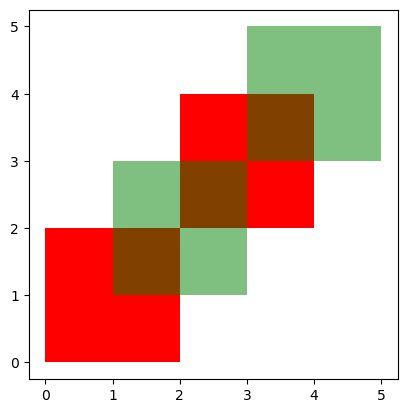

In [41]:
ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5)

In [42]:
# how='union'
res_union = df1.overlay(df2, how='union')
res_union

,df1,df2,geometry
0,1.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2.0,2.0,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."
3,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
4,2.0,NaN,"MULTIPOLYGON (((3.00000 3.00000, 4.00000 3.000..."
5,NaN,1.0,"MULTIPOLYGON (((2.00000 2.00000, 3.00000 2.000..."
6,NaN,2.0,"POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5...."


In [43]:
res_union.explode().reset_index()

/var/folders/f_/jlrntldn06g41fwxs9z9fbjh0000gn/T/ipykernel_13887/1109923995.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  res_union.explode().reset_index()


,level_0,level_1,df1,df2,geometry
0,0,0,1.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,1,0,2.0,1.0,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2,0,2.0,2.0,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."
3,3,0,1.0,NaN,"POLYGON ((2.00000 0.00000, 0.00000 0.00000, 0...."
4,4,0,2.0,NaN,"POLYGON ((3.00000 3.00000, 4.00000 3.00000, 4...."
5,4,1,2.0,NaN,"POLYGON ((3.00000 3.00000, 2.00000 3.00000, 2...."
6,5,0,NaN,1.0,"POLYGON ((2.00000 2.00000, 3.00000 2.00000, 3...."
7,5,1,NaN,1.0,"POLYGON ((2.00000 2.00000, 1.00000 2.00000, 1...."
8,6,0,NaN,2.0,"POLYGON ((3.00000 5.00000, 5.00000 5.00000, 5...."


<Axes: >

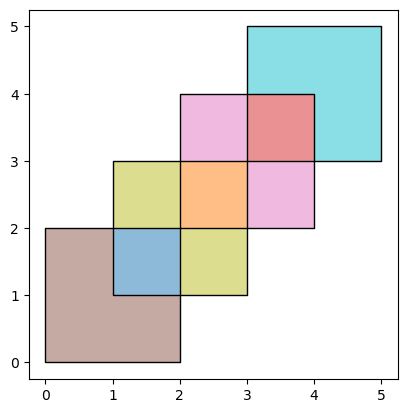

In [44]:
ax = res_union.plot(alpha=0.5, cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k')
df2.plot(ax=ax, facecolor='none', edgecolor='k')

In [45]:
# how='intersection'
res_intersection = df1.overlay(df2, how='intersection')
res_intersection

,df1,df2,geometry
0,1,1,"POLYGON ((2.00000 2.00000, 2.00000 1.00000, 1...."
1,2,1,"POLYGON ((2.00000 2.00000, 2.00000 3.00000, 3...."
2,2,2,"POLYGON ((4.00000 4.00000, 4.00000 3.00000, 3...."


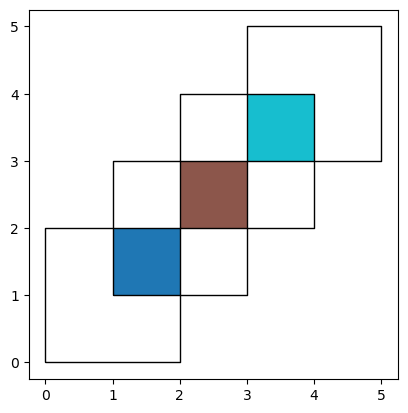

In [46]:
ax = res_intersection.plot(cmap='tab10')

df1.plot(ax=ax, facecolor='none', edgecolor='k');

df2.plot(ax=ax, facecolor='none', edgecolor='k');


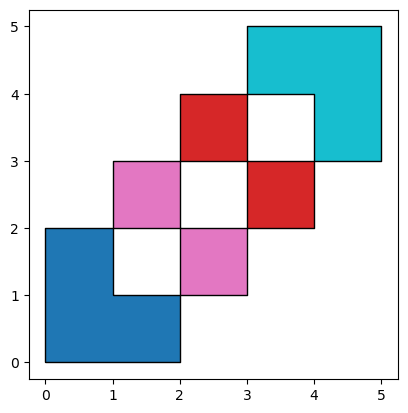

In [47]:
'''
how='symmetric_difference'
the opposite of 'intersection'
'''
res_symdiff = df1.overlay(df2, how='symmetric_difference')
ax = res_symdiff.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

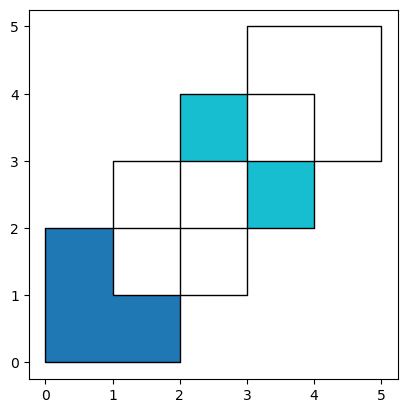

In [48]:
'''
how='difference'
obtain the geometries that are part of df1 but are not contained in df2
'''
res_difference = df1.overlay(df2, how='difference')
ax = res_difference.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');

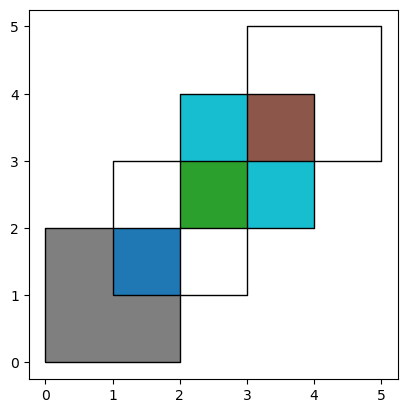

In [49]:
'''
how='identity'
the result consists of the surface of df1, 
but with the geometries obtained from overlaying df1 with df2
'''
res_identity = df1.overlay(df2, how='identity')
ax = res_identity.plot(cmap='tab10')
df1.plot(ax=ax, facecolor='none', edgecolor='k');
df2.plot(ax=ax, facecolor='none', edgecolor='k');


### E.g. the overlap area between long-term care facilities with buffer and administrative districts

In [50]:
long_term_care_buffer = long_term_care[['機構名稱', 'buffer']]
long_term_care_buffer = long_term_care_buffer.set_geometry('buffer')

overlay_df = gpd.overlay(
    long_term_care_buffer, 
    village_border, 
    how='union'
).explode().reset_index()

overlay_df

/var/folders/f_/jlrntldn06g41fwxs9z9fbjh0000gn/T/ipykernel_13887/398861598.py:8: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  ).explode().reset_index()


,level_0,level_1,機構名稱,PTNAME,geometry
0,0,0,士林失能身障日照中心,臺北市士林區,"POLYGON ((303540.798 2775530.143, 303526.398 2..."
1,1,0,士林失能身障日照中心,臺北市中山區,"POLYGON ((303469.493 2775245.477, 303427.534 2..."
2,2,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市中山區,"POLYGON ((303538.889 2771312.112, 303524.490 2..."
3,3,0,士林失能身障日照中心,臺北市大同區,"POLYGON ((302074.216 2774746.239, 302059.273 2..."
4,4,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市大同區,"POLYGON ((301548.520 2771312.112, 301543.704 2..."
5,5,0,臺北市中山身障社區式長照機構（日間照顧）,臺北市中正區,"POLYGON ((303425.626 2770938.733, 303375.174 2..."
6,6,0,臺北市民生身障社區式長照機構（日間照顧）,臺北市內湖區,"POLYGON ((307755.419 2772339.196, 307741.020 2..."
7,7,0,臺北市民生身障社區式長照機構（日間照顧）,臺北市松山區,"POLYGON ((307642.156 2771965.816, 307591.704 2..."
8,8,0,臺北市信義身障社區式長照機構（日間照顧）,臺北市信義區,"POLYGON ((308203.315 2769469.958, 308188.915 2..."
9,9,0,臺北市信義身障社區式長照機構（日間照顧）,臺北市大安區,"POLYGON ((306227.345 2769372.884, 306212.945 2..."


In [51]:
overlay_df['geometry'].area

0     3.044400e+06
1     9.154184e+04
2     1.098532e+06
3     6.069314e+02
4     8.642152e+05
5     1.173800e+06
6     1.378886e+05
7     2.998660e+06
8     3.117763e+06
9     1.878498e+04
10    3.580674e-10
11    2.728973e-09
12    9.589520e-06
13    2.968405e-01
14    9.100278e-03
15    1.314581e-01
16    3.656399e-01
17    1.290126e-03
18    5.995269e-04
19    1.747772e-04
20    1.852653e-06
21    3.297013e-05
22    9.954847e-03
23    6.510426e-03
24    4.390402e-04
25    4.906428e-03
26    5.024801e-03
27    1.686159e-04
28    5.738380e+07
29    5.789722e+07
30    1.661904e+05
31    3.181394e+07
32    1.268632e+07
33    3.906514e+06
34    5.682794e+06
35    2.195662e+07
36    6.368075e+06
37    8.121732e+06
38    7.449655e+06
39    1.132080e+07
40    3.125012e+07
dtype: float64

# Kepler in Python

In [52]:
from keplergl import KeplerGl

map_ = KeplerGl(height=700)
map_.add_data(
    data=overlay_df[overlay_df.area<1], 
    name='overlay_df'
)
map_.add_data(
    data=village_border, 
    name='VB'
)
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


/opt/homebrew/anaconda3/lib/python3.11/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
/opt/homebrew/anaconda3/lib/python3.11/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'overlay_df': {'index': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27…

# 儀表板資料格式轉換

For the input format of the dashboard, you can refer to this [link](https://tuic.gov.taipei/documentation/front-end/chart-data).

## save as GeoJson

In [53]:
long_term_care_buffer = long_term_care_buffer.to_crs('EPSG:4326')
long_term_care_buffer.to_file(
    'Processed_by_ETL/map_data/long_term_care_buffer.geojson', 
    driver='GeoJSON'
)

## save as json

### Two-Dimensional Data

In [54]:
TP_daycare_town = gpd.read_file('Datasets/Processed/TP_daycare_town.geojson')
TP_daycare_town['NUMPOINTS'] = TP_daycare_town['NUMPOINTS'].astype(int)

specified_order = [
    '北投區', '士林區', '內湖區', '南港區', 
    '松山區', '信義區', '中山區', '大同區', 
    '中正區', '萬華區', '大安區', '文山區'
]
mapping = {y: x for x, y in enumerate(specified_order)}

TP_daycare_town['sort_idx'] = TP_daycare_town['TNAME'].apply(lambda x: mapping[x])
TP_daycare_town.sort_values(by=['sort_idx'], inplace=True)

In [55]:
TP_daycare_town.head(5)

,AREA,COUN_ID,PNAME,TNAME,PTNAME,MAX_X,MAX_Y,MIN_X,MIN_Y,NUMPOINTS,geometry,sort_idx
0,5.738380e+07,6301200,臺北市,北投區,臺北市北投區,121.57361,25.21014,121.45871,25.09588,3,"MULTIPOLYGON (((121.52259 25.17489, 121.52259 ...",0
1,6.110781e+07,6301100,臺北市,士林區,臺北市士林區,121.60853,25.19528,121.46145,25.07434,3,"MULTIPOLYGON (((121.57354 25.19386, 121.57383 ...",1
2,3.195183e+07,6301000,臺北市,內湖區,臺北市內湖區,121.62848,25.11483,121.55181,25.05186,2,"MULTIPOLYGON (((121.59560 25.11414, 121.59559 ...",2
6,2.195662e+07,6300900,臺北市,南港區,臺北市南港區,121.66605,25.06432,121.57765,25.01224,1,"MULTIPOLYGON (((121.57979 25.05294, 121.57986 ...",3
5,8.680668e+06,6300100,臺北市,松山區,臺北市松山區,121.58019,25.07587,121.53824,25.04435,2,"MULTIPOLYGON (((121.57610 25.04940, 121.57594 ...",4


In [56]:
results = {
    'data': [
        {
            'name':'', 
            'data': [
                {
                    'x': x, 
                    'y': y
                } 
                for x, y in zip(
                    TP_daycare_town['TNAME'], 
                    TP_daycare_town['NUMPOINTS']
                )
            ]
        }
    ]
}

In [57]:
results

{'data': [{'name': '',
   'data': [{'x': '北投區', 'y': 3},
    {'x': '士林區', 'y': 3},
    {'x': '內湖區', 'y': 2},
    {'x': '南港區', 'y': 1},
    {'x': '松山區', 'y': 2},
    {'x': '信義區', 'y': 4},
    {'x': '中山區', 'y': 4},
    {'x': '大同區', 'y': 1},
    {'x': '中正區', 'y': 3},
    {'x': '萬華區', 'y': 2},
    {'x': '大安區', 'y': 0},
    {'x': '文山區', 'y': 2}]}]}

In [58]:
with open('Processed_by_ETL/chart_data/TP_daycare_town.json', "w") as json_file:
    json.dump(results, json_file, ensure_ascii=False)

### Three-Dimensional Data

In [59]:
disability_demand_trend = pd.read_csv(
    'Datasets/Processed/無障礙需求歷年趨勢.csv', 
    thousands=','
)

disability_demand_trend['年份'] = disability_demand_trend['年份'].str.replace('年', '-01-01')
disability_demand_trend['年份'] = Preload().convert_str_to_time_format(
    column=disability_demand_trend['年份'], 
    from_format='y-m-d'
)
disability_demand_trend['年份'] = disability_demand_trend['年份'].map(
    lambda x: x.isoformat()
).str.replace('+08:00', 'Z')

disability_demand_trend.head(3)

*H* not found, only *ymd*


,年份,日間及住宿式照顧補助金額(元),生活補助金額(元),輔具補助金額(元)
0,1995-01-01T00:00:00Z,37007518,123629720,67958515
1,1996-01-01T00:00:00Z,91367929,265961218,59513472
2,1997-01-01T00:00:00Z,68788296,168770548,63790107


In [60]:
cols = list(disability_demand_trend)
cols.remove('年份')

results = {
    'data': [
        {
            'name': col,
            'data': [
                {
                    'x': x, 
                    'y': y
                } 
                for x, y in zip(
                    disability_demand_trend['年份'], 
                    disability_demand_trend[col]
                )
            ]
        }
        for col in cols
    ]
}

with open('Processed_by_ETL/chart_data/disability_demand_trend.json', "w") as json_file:
    json.dump(results, json_file, ensure_ascii=False)


In [61]:
results

{'data': [{'name': '日間及住宿式照顧補助金額(元)',
   'data': [{'x': '1995-01-01T00:00:00Z', 'y': 37007518},
    {'x': '1996-01-01T00:00:00Z', 'y': 91367929},
    {'x': '1997-01-01T00:00:00Z', 'y': 68788296},
    {'x': '1998-01-01T00:00:00Z', 'y': 174731400},
    {'x': '1999-01-01T00:00:00Z', 'y': 158774563},
    {'x': '2000-01-01T00:00:00Z', 'y': 405985325},
    {'x': '2001-01-01T00:00:00Z', 'y': 613709172},
    {'x': '2002-01-01T00:00:00Z', 'y': 683857039},
    {'x': '2003-01-01T00:00:00Z', 'y': 732591017},
    {'x': '2004-01-01T00:00:00Z', 'y': 596227191},
    {'x': '2005-01-01T00:00:00Z', 'y': 567746993},
    {'x': '2006-01-01T00:00:00Z', 'y': 575093412},
    {'x': '2007-01-01T00:00:00Z', 'y': 530348362},
    {'x': '2008-01-01T00:00:00Z', 'y': 629298222},
    {'x': '2009-01-01T00:00:00Z', 'y': 677897043},
    {'x': '2010-01-01T00:00:00Z', 'y': 745310746},
    {'x': '2011-01-01T00:00:00Z', 'y': 885733255},
    {'x': '2012-01-01T00:00:00Z', 'y': 965652889},
    {'x': '2013-01-01T00:00:00Z', 'y': 

# 實作 - 整理儀表板可用的資料 